## Answer questions

In [342]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [343]:
import pandas as pd
from src.paths import TRANSFORMED_DATA_DIR, MODELS_DIR, RAW_DATA_DIR

In [344]:
# Read metadata json file from models folder
import json

metadata = json.load(open(MODELS_DIR / 'metadata.json'))

In [345]:
print(f'Model being used is: {metadata["name"]}')

Model being used is: Linear regression model


In [346]:
if metadata['name'] == 'Linear regression model':
    data = pd.read_csv(TRANSFORMED_DATA_DIR / 'transformed_data_for_lr.csv')
    data_no_dummies = pd.read_csv(TRANSFORMED_DATA_DIR / 'transformed_data.csv')
else:
    data = pd.read_csv(TRANSFORMED_DATA_DIR / 'transformed_data.csv')

In [347]:
data.shape

(4817, 138)

In [348]:
# Convert date columns to datetime
data['registration_date'] = pd.to_datetime(data['registration_date'])
data['sold_at'] = pd.to_datetime(data['sold_at'])

In [349]:
# Change data types from object to categorical
from src.data import convert_object_columns_to_category

data = convert_object_columns_to_category(data)

In [350]:
from src.data import get_train_test_data

In [351]:
features = metadata['features']
target = metadata['target']

In [352]:
# Print the features
features

['mileage',
 'engine_power',
 'feature_1',
 'feature_2',
 'feature_3',
 'feature_4',
 'feature_5',
 'feature_6',
 'feature_7',
 'feature_8',
 'age_in_months_when_sold',
 'mileage_per_month',
 'model_key_114',
 'model_key_116',
 'model_key_118',
 'model_key_120',
 'model_key_123',
 'model_key_125',
 'model_key_135',
 'model_key_214 Gran Tourer',
 'model_key_216',
 'model_key_216 Active Tourer',
 'model_key_216 Gran Tourer',
 'model_key_218',
 'model_key_218 Active Tourer',
 'model_key_218 Gran Tourer',
 'model_key_220',
 'model_key_220 Active Tourer',
 'model_key_225',
 'model_key_225 Active Tourer',
 'model_key_316',
 'model_key_318',
 'model_key_318 Gran Turismo',
 'model_key_320',
 'model_key_320 Gran Turismo',
 'model_key_325',
 'model_key_325 Gran Turismo',
 'model_key_328',
 'model_key_330',
 'model_key_330 Gran Turismo',
 'model_key_335',
 'model_key_335 Gran Turismo',
 'model_key_418 Gran Coupé',
 'model_key_420',
 'model_key_420 Gran Coupé',
 'model_key_425',
 'model_key_430',


In [353]:
X, y, X_train, X_test, y_train, y_test = get_train_test_data(data, features, target)

In [354]:
import joblib

In [355]:
# Load the model
model = joblib.load(MODELS_DIR / 'model.pkl')

In [356]:
# Print the model
model

LinearRegression()

### Q1

In [357]:
# Read feature importance df from models folder
feature_importance = joblib.load(MODELS_DIR / 'feature_importance_df.pkl')

In [358]:
# In the case of linear regression these are the coefficients
feature_importance

,feature,importance
86,model_key_i8,41117.183922
133,model_initial_i,17138.392556
73,model_key_M4,16772.597677
83,model_key_X6 M,12098.244366
63,model_key_640 Gran Coupé,10375.774381
...,...,...
77,model_key_X3,-9157.386149
71,model_key_M235,-9726.231744
76,model_key_X1,-12736.289962
64,model_key_650,-16461.724894


In [359]:
from src.questions import get_linear_regression_p_values, get_linear_regression_f_test_results

In [360]:
if metadata['name'] == 'Linear regression model':
    coef_p_values_df = get_linear_regression_p_values(X, y, model)
    f_stat, f_test_p_val = get_linear_regression_f_test_results(X, y, model)
else:
    coef_p_values_df = None
    f_stat, f_test_p_val = None, None

In [361]:
coef_p_values_df

,Attribute,Coefficient,P-value
10,age_in_months_when_sold,-125.278858,0.419618
76,model_key_X1,-12561.804364,0.513235
77,model_key_X3,-8976.120933,0.561699
131,model_initial_X,5948.254873,0.579223
122,model_initial_1,-7338.846306,0.595882
...,...,...,...
27,model_key_220 Active Tourer,-400.051439,0.998965
91,paint_color_beige,-56.805429,0.999063
34,model_key_320 Gran Turismo,8.002189,0.999824
109,month_sold_at_1,1.330201,0.999952


In [362]:
print(f'F-statistic: {f_stat}')
print(f'F-test p-value: {f_test_p_val}')

F-statistic: 544209.6521905161
F-test p-value: 1.1102230246251565e-16


In [363]:
from src.plots import plot_shap_summary

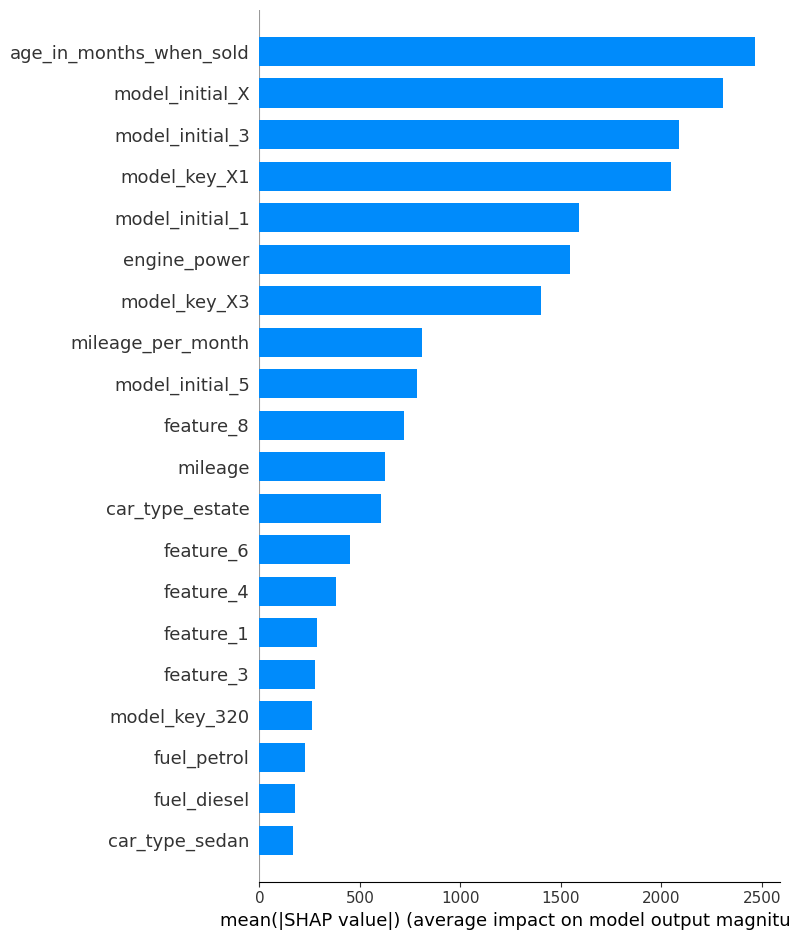

In [364]:
explainer = plot_shap_summary(metadata, model, X)

### Q2

As found during the data exploration phase:
- Except for feature_7, cars with True in the other car features have in average higher prices than cars without them. This suggests that these features will be important for predictive models.
- There seems to be a peak average price in Aug 2018. This may be caused by a sale of a highly price car precisely this month.
- Hybrid and electrical cars are more expensive on average.
- Electrical cars average prices were stable from winter to summer, and were not sold in autumn.
- Diesel and petrol cars had similar average prices, although petrol cars had a drop in average prices starting summer 2018.
- The most expensive car type is, on average, suv, although coupe was most expensive at the start of the year and then dropped below suv also starting in summer.
- Coupe and convertible cars were, on average, more expensive in winter than in summer.
- Vans where more expensive, on average, in spring, summer, and autumn, than in winter.
- Subcompact had generally the lowest average prices.
- Paint color does not seem to generally determine or be associated with the average price, except for color green, which consistently had prices much lower than other colors. Maybe not very popular.
- Orange and white cars were sold for more, on average, during summer than during winter and spring.
- Red cars were the opposite, with lower average prices during summer than during winter and spring.

Find similar observations using estimated price instead of real price

In [365]:
pred = model.predict(X)

In [366]:
if metadata['name'] == 'Linear regression model':
    data_q2 = data_no_dummies.copy()
else:
    data_q2 = data.copy()

In [367]:
data_q2['price'] = pred

In [368]:
from src.plots import plot_avg_target_time_series_by_features

In [369]:
# Load car features
car_features = joblib.load(RAW_DATA_DIR / 'car_features.pkl')

In [370]:
plot_avg_target_time_series_by_features(data_q2, car_features)

In [371]:
# Load small cardinality features
small_cardinality_features = joblib.load(RAW_DATA_DIR / 'small_cardinality_features.pkl')

In [372]:
plot_avg_target_time_series_by_features(data_q2, small_cardinality_features)

In [373]:
from src.questions import make_ttest_results_df

In [374]:
grouping_column = 'season_sold_at'
group_1 = 'winter'
group_2 = 'summer'
ttest_df = make_ttest_results_df(data_q2, small_cardinality_features, grouping_column, group_1, group_2)

In [375]:
ttest_df.sort_values(by='p_val')

,feature,feature_value,t_stat,p_val
8,car_type,sedan,4.295961,0.000021
5,car_type,coupe,2.675371,0.010595
14,paint_color,white,-2.559119,0.011056
6,car_type,estate,1.999919,0.045869
11,car_type,van,-1.983282,0.063729
1,fuel,petrol,1.716293,0.090349
4,car_type,convertible,1.614211,0.122149
10,car_type,suv,-1.275097,0.202762
9,car_type,subcompact,0.894580,0.375992
0,fuel,diesel,-0.874259,0.382069


### Q3

In [376]:
today_date = '3/1/2024'

In [377]:
data_q3 = data.copy()

In [378]:
# Convert date columns to datetime and mock the sold_at date as today's date
data_q3['registration_date'] = pd.to_datetime(data_q3['registration_date'])
data_q3['sold_at'] = today_date
data_q3['sold_at'] = pd.to_datetime(data_q3['sold_at'])

In [379]:
# Calculate age in month at today date and replace in data_q3
data_q3['age_in_months_when_sold'] = (data_q3['sold_at'].dt.to_period('M') - data_q3['registration_date'].dt.to_period('M')).apply(lambda x: x.n)

In [380]:
# Update estimated mileage at today date
data_q3['mileage'] = data_q3['age_in_months_when_sold'] * data_q3['mileage_per_month']

In [381]:
data_q3[['registration_date', 'sold_at', 'age_in_months_when_sold', 'mileage']].head()

,registration_date,sold_at,age_in_months_when_sold,mileage
0,2012-02-01,2024-03-01,145,286754.859155
1,2016-04-01,2024-03-01,95,60147.954545
2,2012-04-01,2024-03-01,143,374449.585714
3,2014-07-01,2024-03-01,116,345396.744186
4,2014-12-01,2024-03-01,111,269444.175000


In [382]:
X_q3, y_q3, X_train_q3, X_test_q3, y_train_q3, y_test_q3 = get_train_test_data(data_q3, features, target)

In [383]:
# Get estimated prices today
pred_q3 = model.predict(X_q3)

In [384]:
# Add 1 year to the age_in_months_when_sold
X_q3['age_in_months_when_sold'] = X_q3['age_in_months_when_sold'] + 12

In [385]:
# Add 1 year worth of mileage
X_q3['mileage'] = X_q3['mileage'] + 12 * data_q3['mileage_per_month']

In [386]:
# Get estimated prices 1 year later
pred_q3_one_year_later = model.predict(X_q3)

In [387]:
X_q3['price_today'] = pred_q3
X_q3['price_one_year_later'] = pred_q3_one_year_later
X_q3['loss'] = X_q3['price_today'] - X_q3['price_one_year_later'] 

In [388]:
price_today_threshold = 20000
loss_threshold = 2000

In [389]:
# Indentify cars that are candidates for buying
candidate_cars = X_q3[(X_q3['price_today'] >= price_today_threshold) & (X_q3['loss'] <= loss_threshold)]

In [390]:
# Show top 10 candidate cars with lowest loss
candidate_cars.sort_values('loss').head(10)

,mileage,engine_power,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,model_initial_6,model_initial_7,model_initial_A,model_initial_M,model_initial_X,model_initial_Z,model_initial_i,price_today,price_one_year_later,loss
4346,3090.600000,183,True,True,False,False,False,False,True,True,...,False,False,False,False,True,False,False,29935.426528,28426.966494,1508.460034
3910,9278.857143,155,True,True,False,True,True,True,True,True,...,False,False,False,False,True,False,False,31592.271864,30072.070768,1520.201096
4121,13241.250000,423,True,True,True,False,False,False,True,True,...,False,False,False,False,True,False,False,53966.674303,52442.647454,1524.026849
4705,18844.800000,230,True,True,False,True,False,False,False,True,...,False,False,False,False,True,False,False,38051.988528,36518.360890,1533.627638
2980,23582.695652,160,True,True,True,False,True,True,True,True,...,False,False,False,False,False,False,False,20844.568206,19304.042329,1540.525877
4675,41148.046512,160,True,True,True,False,False,False,True,True,...,False,False,False,False,True,False,False,27002.808746,25443.097867,1559.710879
2664,37186.666667,195,True,True,True,False,False,True,True,True,...,False,False,False,False,False,False,False,24150.234801,22584.743796,1565.491005
3718,47620.666667,160,True,True,True,False,False,False,True,True,...,False,False,False,False,True,False,False,25963.001855,24394.424783,1568.577072
4595,46011.000000,190,True,True,True,True,False,True,True,True,...,False,False,False,False,True,False,False,34362.458783,32785.882446,1576.576337
67,66996.268657,309,True,True,False,False,True,True,True,True,...,False,False,False,True,False,False,False,33679.615905,32101.628814,1577.987092


In [391]:
# Find the value counts for model_key in candidate_cars if exists. If not try model key initial.
if metadata['name'] == 'Linear regression model':
    model_related_value_counts = None
else:
    try:
        model_related_value_counts = candidate_cars['model_key'].value_counts()
    except KeyError:
        model_related_value_counts = candidate_cars['model_initial'].value_counts()
    model_related_value_counts

In [392]:
model_related_value_counts

In [393]:
# Describe numerical features of candidate cars
candidate_cars.describe()

,mileage,engine_power,age_in_months_when_sold,mileage_per_month,price_today,price_one_year_later,loss
count,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000
mean,221566.384808,207.434307,129.065693,1701.895985,26382.215585,24594.455984,1787.759601
std,93220.667565,46.300947,16.801014,673.623057,6340.072729,6376.579813,112.572895
min,3090.600000,120.000000,92.000000,30.600000,20032.297037,18111.021146,1508.460034
25%,162487.677540,190.000000,119.250000,1226.604403,22734.340935,20891.878869,1708.330981
50%,221682.001273,190.000000,127.000000,1687.708333,25251.692294,23434.227390,1785.388623
75%,285930.723214,230.000000,134.000000,2175.688626,28067.891883,26366.222563,1866.937724
max,458347.605263,423.000000,198.000000,2969.355556,85851.027396,84270.919350,1999.571818


In [394]:
# Show the car with the lowest loss
car_index = candidate_cars.sort_values('loss').index[0]
data_q3.loc[car_index]

maker_key                            BMW
mileage                           2723.4
engine_power                         183
registration_date    2016-10-01 00:00:00
feature_1                           True
                            ...         
model_initial_A                    False
model_initial_M                    False
model_initial_X                     True
model_initial_Z                    False
model_initial_i                    False
Name: 4346, Length: 138, dtype: object

In [395]:
data.loc[car_index]

maker_key                            BMW
mileage                              612
engine_power                         183
registration_date    2016-10-01 00:00:00
feature_1                           True
                            ...         
model_initial_A                    False
model_initial_M                    False
model_initial_X                     True
model_initial_Z                    False
model_initial_i                    False
Name: 4346, Length: 138, dtype: object

In [396]:
X_q3.loc[car_index]

mileage                       3090.6
engine_power                     183
feature_1                       True
feature_2                       True
feature_3                      False
                            ...     
model_initial_Z                False
model_initial_i                False
price_today             29935.426528
price_one_year_later    28426.966494
loss                     1508.460034
Name: 4346, Length: 137, dtype: object

In [397]:
# Check cars with the same model_key
if metadata['name'] == 'Linear regression model':
    cars_same_model_key = data_no_dummies[data_no_dummies['model_key'] == data_no_dummies['model_key'].loc[car_index]].sort_values(
        'price', ascending=False)[['model_key', 'price', 'mileage', 'age_in_months_when_sold']]
else:
    cars_same_model_key = data[data['model_key'] == data['model_key'].loc[car_index]].sort_values(
        'price', ascending=False)[['model_key', 'price', 'mileage', 'age_in_months_when_sold']]
    
cars_same_model_key

,model_key,price,mileage,age_in_months_when_sold
4588,X5,55700,24912,22
3993,X5,52200,33639,21
4645,X5,50600,80307,54
4525,X5,50000,82397,39
4346,X5,49100,612,20
...,...,...,...,...
4423,X5,5100,249546,171
4607,X5,4600,217045,169
4678,X5,3600,220242,180
4347,X5,3500,350615,205


Explain individual prediction with SHAP

In [398]:
X_q3_for_shap = X_q3[X.columns]

In [399]:
from src.plots import plot_shap_waterfall_for_car_sample

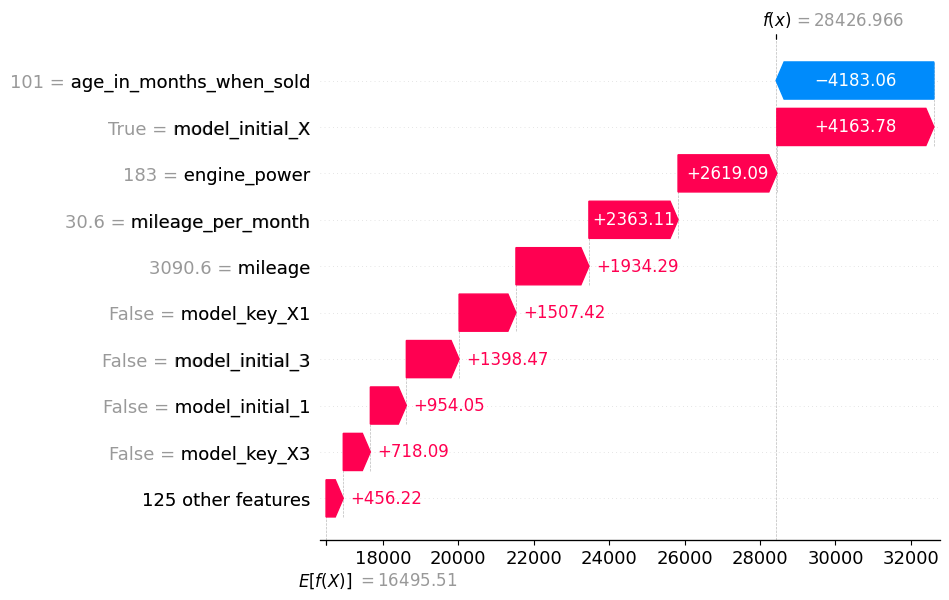

In [400]:
plot_shap_waterfall_for_car_sample(metadata, explainer, X_q3_for_shap, car_index)

Explain with SHAP one year before

In [401]:
# Remove 1 year changes
X_q3['age_in_months_when_sold'] = X_q3['age_in_months_when_sold'] - 12
X_q3['mileage'] = X_q3['mileage'] - 12 * data_q3['mileage_per_month']

In [402]:
X_q3_for_shap = X_q3[X.columns]

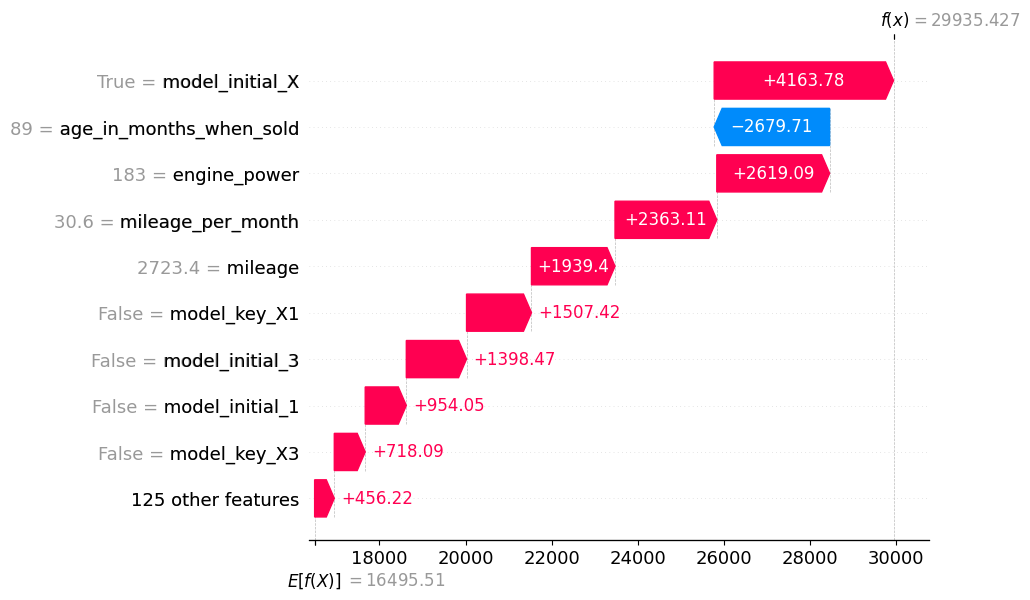

In [403]:
plot_shap_waterfall_for_car_sample(metadata, explainer, X_q3_for_shap, car_index)

### Q3 assumming today is a month after latest sold at date in the data

In [404]:
today_date = data['sold_at'].max()

In [405]:
data_q3 = data.copy()

In [406]:
# Convert date columns to datetime and mock the sold_at date as today's date
data_q3['registration_date'] = pd.to_datetime(data_q3['registration_date'])
data_q3['sold_at'] = today_date
data_q3['sold_at'] = pd.to_datetime(data_q3['sold_at'])

In [407]:
# Calculate mileage per month
data_q3['mileage_per_month'] = data_q3['mileage'] / data_q3['age_in_months_when_sold']

In [408]:
# Calculate age in month at today date and replace in data_q3
data_q3['age_in_months_when_sold'] = (data_q3['sold_at'].dt.to_period('M') - data_q3['registration_date'].dt.to_period('M')).apply(lambda x: x.n)

In [409]:
# Update estimated mileage at today date
data_q3['mileage'] = data_q3['age_in_months_when_sold'] * data_q3['mileage_per_month']

In [410]:
data_q3[['registration_date', 'sold_at', 'age_in_months_when_sold', 'mileage']].head()

,registration_date,sold_at,age_in_months_when_sold,mileage
0,2012-02-01,2018-09-01,79,156231.957746
1,2016-04-01,2018-09-01,29,18360.954545
2,2012-04-01,2018-09-01,77,201626.700000
3,2014-07-01,2018-09-01,50,148877.906977
4,2014-12-01,2018-09-01,45,109234.125000


In [411]:
X_q3, y_q3, X_train_q3, X_test_q3, y_train_q3, y_test_q3 = get_train_test_data(data_q3, features, target)

In [412]:
# Get estimated prices today
pred_q3 = model.predict(X_q3)

In [413]:
# Add 1 year to the age_in_months_when_sold
X_q3['age_in_months_when_sold'] = X_q3['age_in_months_when_sold'] + 12

In [414]:
# Add 1 year worth of mileage
X_q3['mileage'] = X_q3['mileage'] + 12 * data_q3['mileage_per_month']

In [415]:
# Get estimated prices 1 year later
pred_q3_one_year_later = model.predict(X_q3)

In [416]:
X_q3['price_today'] = pred_q3
X_q3['price_one_year_later'] = pred_q3_one_year_later
X_q3['loss'] = X_q3['price_today'] - X_q3['price_one_year_later'] 

In [417]:
# Indentify cars that are candidates for buying
candidate_cars = X_q3[(X_q3['price_today'] >= price_today_threshold) & (X_q3['loss'] <= loss_threshold)]

In [418]:
# Show top 10 candidate cars with lowest loss
candidate_cars.sort_values('loss').head(10)

,mileage,engine_power,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,model_initial_6,model_initial_7,model_initial_A,model_initial_M,model_initial_X,model_initial_Z,model_initial_i,price_today,price_one_year_later,loss
2400,597.333333,120,True,True,False,False,False,True,True,True,...,False,False,False,False,False,False,False,26699.437474,25194.531430,1504.906043
4346,1071.000000,183,True,True,False,False,False,False,True,True,...,False,False,False,False,True,False,False,38231.956716,36723.496682,1508.460034
3910,2622.285714,155,True,True,False,True,True,True,True,True,...,False,False,False,False,True,False,False,39953.377892,38433.176796,1520.201096
4121,5073.750000,423,True,True,True,False,False,False,True,True,...,False,False,False,False,True,False,False,62348.821971,60824.795122,1524.026849
4705,6885.600000,230,True,True,False,True,False,False,False,True,...,False,False,False,False,True,False,False,46486.940535,44953.312898,1533.627638
4353,15729.389831,120,True,True,True,True,False,False,True,True,...,False,False,False,False,True,False,False,23130.962079,21592.093810,1538.868268
2980,8899.130435,160,True,True,True,False,True,True,True,True,...,False,False,False,False,False,False,False,29317.460532,27776.934654,1540.525877
3667,10796.857143,75,True,True,True,False,False,False,True,True,...,False,False,False,False,False,False,True,27273.056817,25730.486110,1542.570708
3314,23688.750000,120,False,True,False,True,True,True,True,True,...,False,False,False,False,False,False,False,20138.168741,18582.038993,1556.129748
4675,18887.627907,160,True,True,True,False,False,False,True,True,...,False,False,False,False,True,False,False,35581.218581,34021.507702,1559.710879


In [419]:
# Find the value counts for model_key in candidate_cars if exists. If not try model key initial.
if metadata['name'] == 'Linear regression model':
    model_related_value_counts = None
else:
    try:
        model_related_value_counts = candidate_cars['model_key'].value_counts()
    except KeyError:
        model_related_value_counts = candidate_cars['model_initial'].value_counts()
    model_related_value_counts

In [420]:
model_related_value_counts

In [421]:
# Describe numerical features of candidate cars
candidate_cars.describe()

,mileage,engine_power,age_in_months_when_sold,mileage_per_month,price_today,price_one_year_later,loss
count,783.000000,783.000000,783.00000,783.000000,783.000000,783.000000,783.000000
mean,121886.224905,178.856960,69.37037,1741.704426,27950.514279,26156.102068,1794.412211
std,56899.103864,45.852287,21.65613,647.705439,7418.863411,7432.367858,108.241658
min,597.333333,75.000000,26.00000,9.333333,20005.908219,18107.572983,1504.906043
25%,79738.533333,140.000000,58.00000,1273.252886,22080.358983,20319.485239,1716.126669
50%,120374.923077,190.000000,65.00000,1760.130435,25475.627279,23663.219177,1797.491483
75%,157452.103118,210.000000,76.00000,2224.456420,33090.585138,31262.850625,1875.087581
max,399913.500000,423.000000,147.00000,2969.600000,94541.621647,92961.513602,1999.612668


In [422]:
# Show the car with the lowest loss
car_index = candidate_cars.sort_values('loss').index[0]
data_q3.loc[car_index]

maker_key                            BMW
mileage                       485.333333
engine_power                         120
registration_date    2014-05-01 00:00:00
feature_1                           True
                            ...         
model_initial_A                    False
model_initial_M                    False
model_initial_X                    False
model_initial_Z                    False
model_initial_i                    False
Name: 2400, Length: 138, dtype: object

In [423]:
data.loc[car_index]

maker_key                            BMW
mileage                              476
engine_power                         120
registration_date    2014-05-01 00:00:00
feature_1                           True
                            ...         
model_initial_A                    False
model_initial_M                    False
model_initial_X                    False
model_initial_Z                    False
model_initial_i                    False
Name: 2400, Length: 138, dtype: object

In [424]:
X_q3.loc[car_index]

mileage                   597.333333
engine_power                     120
feature_1                       True
feature_2                       True
feature_3                      False
                            ...     
model_initial_Z                False
model_initial_i                False
price_today             26699.437474
price_one_year_later     25194.53143
loss                     1504.906043
Name: 2400, Length: 137, dtype: object

In [425]:
# Check cars with the same model_key
if metadata['name'] == 'Linear regression model':
    cars_same_model_key = data_no_dummies[data_no_dummies['model_key'] == data_no_dummies['model_key'].loc[car_index]].sort_values(
        'price', ascending=False)[['model_key', 'price', 'mileage', 'age_in_months_when_sold']]
else:
    cars_same_model_key = data[data['model_key'] == data['model_key'].loc[car_index]].sort_values(
        'price', ascending=False)[['model_key', 'price', 'mileage', 'age_in_months_when_sold']]
    
cars_same_model_key

,model_key,price,mileage,age_in_months_when_sold
2170,420 Gran Coupé,32100,27547,28
2400,420 Gran Coupé,30300,476,51
1806,420 Gran Coupé,30200,104133,34
2138,420 Gran Coupé,29800,64380,30
2222,420 Gran Coupé,29500,40168,39
1904,420 Gran Coupé,29500,27966,22
3403,420 Gran Coupé,29300,54836,52
2422,420 Gran Coupé,29200,77358,41
2395,420 Gran Coupé,28100,64500,45
1978,420 Gran Coupé,27400,139258,41


Explain individual prediction with SHAP

In [426]:
X_q3_for_shap = X_q3[X.columns]

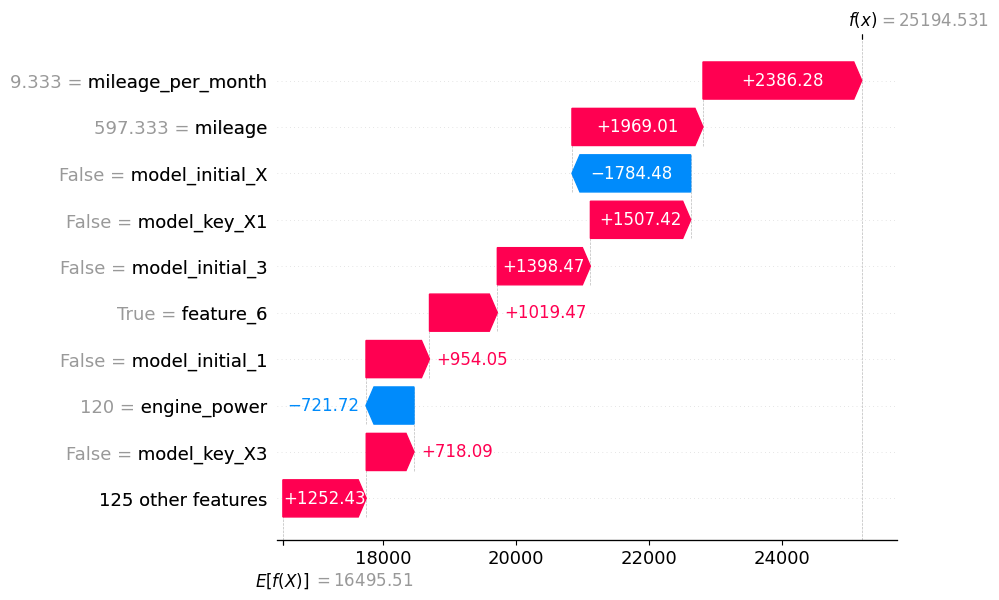

In [427]:
plot_shap_waterfall_for_car_sample(metadata, explainer, X_q3_for_shap, car_index)

Explain with SHAP one year before

In [428]:
# Remove 1 year changes
X_q3['age_in_months_when_sold'] = X_q3['age_in_months_when_sold'] - 12
X_q3['mileage'] = X_q3['mileage'] - 12 * data_q3['mileage_per_month']

In [429]:
X_q3_for_shap = X_q3[X.columns]

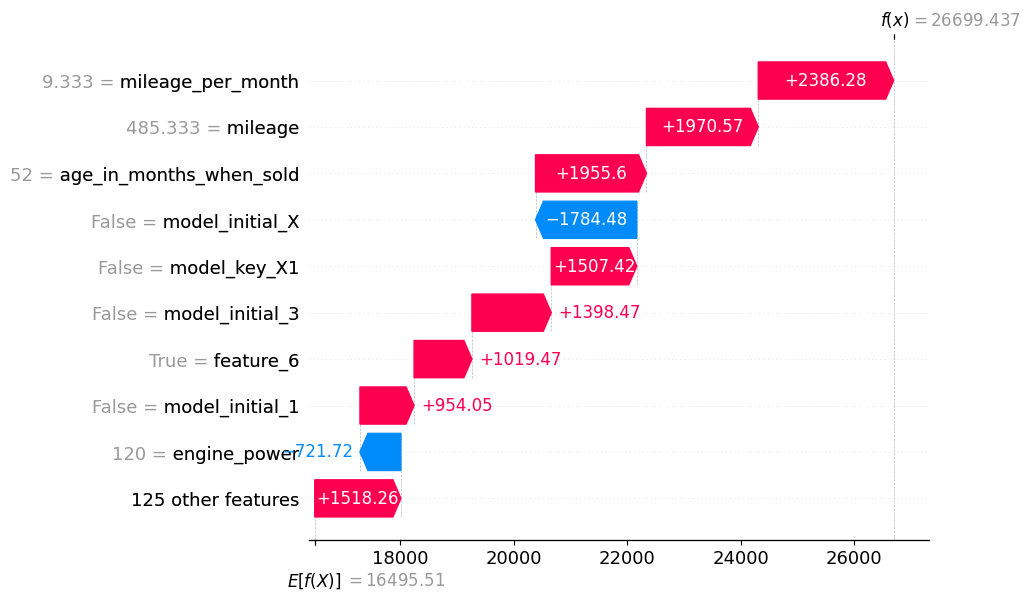

In [430]:
plot_shap_waterfall_for_car_sample(metadata, explainer, X_q3_for_shap, car_index)

### Q4

In [431]:
print(f'Test MSE: {metadata["mse_test"]:.2f}')
print(f'Test RMSE: {metadata["rmse_test"]:.2f}')
print(f'Test MAE: {metadata["mae_test"]:.2f}')
print(f'Test R2: {metadata["r2_test"]:.2f}')

Test MSE: 11259962.94
Test RMSE: 3355.59
Test MAE: 2273.41
Test R2: 0.83


### Q5

#### Data quality

There are no null values in the data.

There are no infinite values in the data.

There are no duplicates.

From the number of unique feature values we can observe that:
- There is only one maker (BWM). So, this feature will not give information to the models.
- There are 199 different registration dates.
- feature_1 to feature_8 are binary variables.
- The auction happened in 9 different dates.

Looking at the description of numerical features, hints that there are possibly erroneous observations. For example:
- a car with -64 miles,
- a car with 0 (I assume hp) engine power, 
- and a car that costed 100 (I assume USD)

Therefore, data needs some further cleaning.

There is a 640 Gran Coupé with negative mileage which is not possible. Also, there are other 18 cars of the same model key, so this row will be removed.

This is a 13 year-old car (159 months) with more than a million miles. Although strange, it is not impossible that it has driven this many miles (about 210 in average daily). So this observation is not recommended to be removed.

There is a wrong observation with 0 engine power for an X1 which is a SUV. This is impossible. Since there are more than 200 other X1 this observation can be removed.

Very likely the engine power of 25 (hp) for two i3 is wrong. These cars should have 75 (hp) engine power, so this is probably a typo. Since there are very few other i3 cars, data imputation might be a better alternative here to dropping the records. According to most values, a good candidate value for imputation is 75.

Regarding models 316 and 318, since there are more than 200 hundred other observations with the same model, and these cars typically have at least 75 of engine power, these records can also be deleted.

There were 62 cars sold at less than 1,000 which is very unusual. Looking at a description of the numerical features of these cars we find:
- The newest car sold at this price was less than 3 years old. This seems unusual.
- The oldest car was 24 years old.
- Minimum and max mileage seem sensible.

Prices below 800 seem more unusual and might correspond to cars with important damages. Since cars with engine damages were removed before, these other cars with important damages could be removed as well and maybe priced with another strategy.

#### Data distribution (after cleaning)

The features still have very high values after removing the data that probably had errors. 
Examples are:
- 1M miles drove. This can be rare but possible for old cars. 
- A few cars costed more than 100k, which is also possible depending on the car.
- There are some cars with engine power above 400, which can happen for sports cars.
- There are cars as old as 22 years, which is also possible.

These values do not suggest that further data cleaning is needed.

#### Numerical features vs. price

Based on the scatter plots, the following observations can be made:
- As expected, prices tend to decrease with mileage.
- As expected, prices tend to increase with engine power.
- As expected, prices tend to decrease with age.